
# Graph Classification with DGL

Here we demonstrate how to use DGL to finish graph classification tasks. 

In [1]:
import dgl
from dgl.data import TUDataset
from dgl.data.utils import split_dataset
from dgl.nn.pytorch import conv

Using backend: pytorch


In [2]:
import numpy as np
import networkx as nx

import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch.nn.functional as F

## Load Dataset

<img src="../asset/enzymes.png" width="500"/>

Here we use an enzymes dataset. It constructs graphs from the enzymes based on group functions. Nodes means structure elements and edges means the connections between them. Each graph has a label from 0-5, which means the type of the enzymes.

In [3]:
dataset = TUDataset("ENZYMES")

dataset.graph_labels=torch.tensor(dataset.graph_labels)
for i in range(len(dataset)):
    dataset[i][0].ndata['node_attr']=(dataset[i][0].ndata['node_attr']).float()

Extracting file to /home/ubuntu/.dgl/ENZYMES


/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
graph, label= dataset[0]
print(graph)
print(label)

Graph(num_nodes=37, num_edges=168,
      ndata_schemes={'node_labels': Scheme(shape=(1,), dtype=torch.int64), 'node_attr': Scheme(shape=(18,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})
tensor([5])


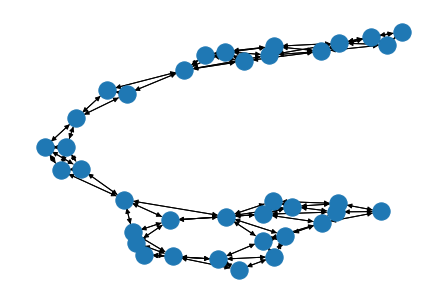

In [5]:
nx.draw_spring(graph.to_networkx())

### Split dataset into train and val

In [6]:
trainset, valset = split_dataset(dataset, [0.8, 0.2], shuffle=True, random_state=42)

## Prepare Dataloader

DGL could batch multiple small graphs together to accelerate the computation. Detail of batching can be found [here](https://docs.dgl.ai/tutorials/basics/4_batch.html).

<img src="https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/batch.png" width="500"/>

In [7]:
def collate_molgraphs_for_classification(data):
    """Batching a list of datapoints for dataloader in classification tasks."""
    graphs, labels = map(list, zip(*data))
    bg = dgl.batch(graphs)
    labels = torch.stack(labels, dim=0)
    return bg, labels

train_loader = DataLoader(trainset, batch_size=512,
                          collate_fn=collate_molgraphs_for_classification)
val_loader = DataLoader(valset, batch_size=512,
                        collate_fn=collate_molgraphs_for_classification)

## Prepare Model and Optimizer

Here we use a two layer Graph Convolutional Network to classify the graphs. Detailed source code can be found [here](https://github.com/dmlc/dgl/blob/master/python/dgl/model_zoo/chem/classifiers.py#L111).

We use the similar structure as introduced before, a 3-layer GNN to learn the node-level representations. Then we use built-in readout functions `dgl.sum_nodes`, suming all the node(vertex) representation to get the graph representsions. $$h_g=\sum{h_v}$$  
Then we use a linear(MLP) classifier to classify the graph based on its representation

In [8]:
class GCNModel(nn.Module):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 out_feats):
        super().__init__()
        self.layers = nn.ModuleList([
            conv.GraphConv(in_feats, n_hidden, activation=F.relu, allow_zero_in_degree=True),
            conv.GraphConv(n_hidden, n_hidden, activation=F.relu, allow_zero_in_degree=True),
            conv.GraphConv(n_hidden, n_hidden, activation=F.relu, allow_zero_in_degree=True)
        ])
        
        self.classifier = nn.Linear(n_hidden, out_feats)

    def forward(self, g, features):
        h = features
        for layer in self.layers:
            h = layer(g, h)
        with g.local_scope():
            g.ndata['feat'] = h
            h_g = dgl.sum_nodes(g, 'feat')
        return self.classifier(h_g)

## Training

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 500
model = GCNModel(in_feats=18, n_hidden=64, out_feats=6).to(device)
loss_criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())
print(device)
print(model)

cuda
GCNModel(
  (layers): ModuleList(
    (0): GraphConv(in=18, out=64, normalization=both, activation=<function relu at 0x7fc4e71f6f28>)
    (1): GraphConv(in=64, out=64, normalization=both, activation=<function relu at 0x7fc4e71f6f28>)
    (2): GraphConv(in=64, out=64, normalization=both, activation=<function relu at 0x7fc4e71f6f28>)
  )
  (classifier): Linear(in_features=64, out_features=6, bias=True)
)


In [12]:
model.train()
for i in range(epochs):
    loss_list = []
    true_samples = 0
    num_samples = 0
    for batch_id, batch_data in enumerate(train_loader):
        bg, labels = batch_data
        atom_feats = bg.ndata.pop('node_attr').float()
        bg=bg.to(device)
        atom_feats, labels = atom_feats.to(device), \
                                   labels.to(device).squeeze(-1)
        logits = model(bg, atom_feats)
        loss = loss_criterion(logits, labels)
        true_samples += (logits.argmax(1)==labels.long()).float().sum().item()
        num_samples += len(labels)
        loss_list.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if i%10==0:
        print("Epoch {:05d} | Loss: {:.4f} | Accuracy: {:.4f}".format(i, np.mean(loss_list), true_samples/num_samples))

Epoch 00000 | Loss: 1.2574 | Accuracy: 0.5229
Epoch 00010 | Loss: 1.2522 | Accuracy: 0.5125
Epoch 00020 | Loss: 1.2472 | Accuracy: 0.5146
Epoch 00030 | Loss: 1.2423 | Accuracy: 0.5229
Epoch 00040 | Loss: 1.2375 | Accuracy: 0.5271
Epoch 00050 | Loss: 1.2326 | Accuracy: 0.5312
Epoch 00060 | Loss: 1.2281 | Accuracy: 0.5292
Epoch 00070 | Loss: 1.2235 | Accuracy: 0.5375
Epoch 00080 | Loss: 1.2189 | Accuracy: 0.5375
Epoch 00090 | Loss: 1.2142 | Accuracy: 0.5458
Epoch 00100 | Loss: 1.2093 | Accuracy: 0.5479
Epoch 00110 | Loss: 1.2044 | Accuracy: 0.5563
Epoch 00120 | Loss: 1.1996 | Accuracy: 0.5604
Epoch 00130 | Loss: 1.1947 | Accuracy: 0.5667
Epoch 00140 | Loss: 1.1896 | Accuracy: 0.5646
Epoch 00150 | Loss: 1.1845 | Accuracy: 0.5687
Epoch 00160 | Loss: 1.1795 | Accuracy: 0.5687
Epoch 00170 | Loss: 1.1738 | Accuracy: 0.5667
Epoch 00180 | Loss: 1.1683 | Accuracy: 0.5729
Epoch 00190 | Loss: 1.1627 | Accuracy: 0.5687
Epoch 00200 | Loss: 1.1572 | Accuracy: 0.5729
Epoch 00210 | Loss: 1.1517 | Accur

## Validation

In [14]:
model.eval()
true_samples = 0
num_samples = 0
with torch.no_grad():
    for batch_id, batch_data in enumerate(val_loader):
        bg, labels = batch_data
        bg=bg.to(device)
        atom_feats = bg.ndata.pop('node_attr')
        atom_feats, labels = atom_feats.to(device), \
                                   labels.to(device).squeeze(-1)
        logits = model(bg, atom_feats)
        logits.argmax()
        num_samples += len(labels)
        true_samples += (logits.argmax(1)==labels.long()).float().sum().item()
print("Validation Accuracy: {:.4f}".format(true_samples/num_samples))

Validation Accuracy: 0.4500


## Excercise

There's other built-in readout function, such as `max_nodes` and `mean_nodes`. Docs can be found [here](https://docs.dgl.ai/api/python/batch.html#graph-readout). You can try to replace the `sum_nodes` with other functions to see whether you could acheive better performances.
You can also change the network structure as the exercise of `BasicTask.ipynb`